## Data format of a traffic scene

This notebook dives into the data format used to create simulations in Nocturne.

_Last update: 10/2023_

In [3]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cmap = ['r', 'g', 'b', 'y', 'c'] 
%config InlineBackend.figure_format = 'svg'
sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (8, 3)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})

Traffic scenes are constructed by utilizing the [Waymo Open Motion dataset](https://waymo.com/open/). Though every scene is unique, they all have the same basic data structure. 

To load a traffic scene:

In [11]:
# Take an example scene
data_path = '../data/example_scenario.json'

with open(data_path) as file:
    traffic_scene = json.load(file)

traffic_scene.keys()

dict_keys(['name', 'objects', 'roads', 'tl_states'])

### Global Overview 
A traffic scene consists of:
- `name`: the name of the traffic scenario.
- `objects`: the road objects or moving vehicles in the scene.
- `roads`: the road points in the scene, these are all the stationary objects.
- `tl_states`: the states of the traffic lights, which are filtered out for now. 

In [12]:
traffic_scene['tl_states']

{}

In [13]:
traffic_scene['name']

'tfrecord-00358-of-01000_65.json'

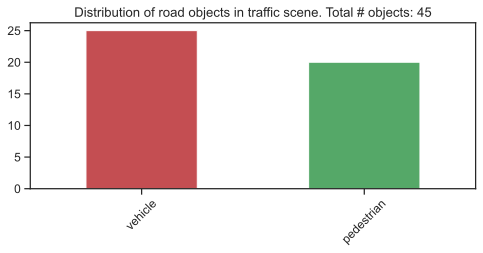

In [14]:
pd.Series(
    [
        traffic_scene['objects'][idx]['type']
        for idx in range(len(traffic_scene['objects']))
    ]
).value_counts().plot(kind='bar', rot=45, color=cmap);
plt.title(f'Distribution of road objects in traffic scene. Total # objects: {len(traffic_scene["objects"])}')
plt.show()

This traffic scenario only contains vehicles and pedestrians, some scenes have cyclists as well.

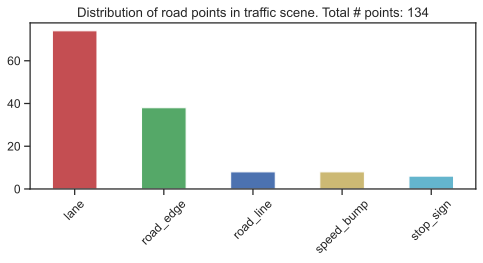

In [15]:
pd.Series(
    [
        traffic_scene['roads'][idx]['type']
        for idx in range(len(traffic_scene['roads']))
    ]
).value_counts().plot(kind='bar', rot=45, color=cmap);
plt.title(f'Distribution of road points in traffic scene. Total # points: {len(traffic_scene["roads"])}')
plt.show()

### In-Depth: Road Objects

This is a list of different road objects in the traffic scene. For each road object, we have information about its position, velocity, size, in which direction it's heading, whether it's a valid object, the type, and the final position of the vehicle.

In [16]:
# Take the first object
idx = 0

# For each object, we have this information:
traffic_scene['objects'][idx].keys()

dict_keys(['position', 'width', 'length', 'heading', 'velocity', 'valid', 'goalPosition', 'type'])

In [17]:
# Position contains the (x, y) coordinates for the vehicle at every time step
print(json.dumps(traffic_scene['objects'][idx]['position'][:10], indent=4))

[
    {
        "x": 9037.7138671875,
        "y": -2720.373779296875
    },
    {
        "x": 9037.7607421875,
        "y": -2720.306640625
    },
    {
        "x": 9037.822265625,
        "y": -2720.217529296875
    },
    {
        "x": 9037.8916015625,
        "y": -2720.146240234375
    },
    {
        "x": 9037.9482421875,
        "y": -2720.070068359375
    },
    {
        "x": 9038.01953125,
        "y": -2719.994384765625
    },
    {
        "x": 9038.1005859375,
        "y": -2719.903076171875
    },
    {
        "x": 9038.1953125,
        "y": -2719.830810546875
    },
    {
        "x": 9038.279296875,
        "y": -2719.74462890625
    },
    {
        "x": 9038.3564453125,
        "y": -2719.674560546875
    }
]


In [18]:
# Width and length together make the size of the object, and is used to see if there is a collision 
traffic_scene['objects'][idx]['width'], traffic_scene['objects'][idx]['length'] 

(0.6877052187919617, 0.6777269244194031)

An object's heading refers to the direction it is pointing or moving in. The default coordinate system in Nocturne is right-handed, where the positive x and y axes point to the right and downwards, respectively. In a right-handed coordinate system, 0 degrees is located on the x-axis and the angle increases counter-clockwise.

Because the scene is created from the viewpoint of an ego driver, there may be instances where the heading of certain vehicles is not available. These cases are represented by the value `-10_000`, to indicate that these steps should be filtered out or are invalid.

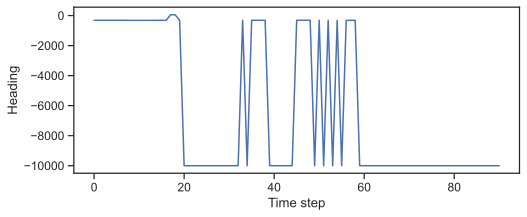

In [19]:
# Heading is the direction in which the vehicle is pointing 
plt.plot(traffic_scene['objects'][idx]['heading']);
plt.xlabel('Time step')
plt.ylabel('Heading')
plt.show()

In [20]:
# Velocity shows the velocity in the x- and y- directions
print(json.dumps(traffic_scene['objects'][idx]['velocity'][:10], indent=4))

[
    {
        "x": 0.634765625,
        "y": 0.72265625
    },
    {
        "x": 0.46875,
        "y": 0.67138671875
    },
    {
        "x": 0.615234375,
        "y": 0.89111328125
    },
    {
        "x": 0.693359375,
        "y": 0.712890625
    },
    {
        "x": 0.56640625,
        "y": 0.76171875
    },
    {
        "x": 0.712890625,
        "y": 0.7568359375
    },
    {
        "x": 0.810546875,
        "y": 0.9130859375
    },
    {
        "x": 0.947265625,
        "y": 0.72265625
    },
    {
        "x": 0.83984375,
        "y": 0.86181640625
    },
    {
        "x": 0.771484375,
        "y": 0.70068359375
    }
]


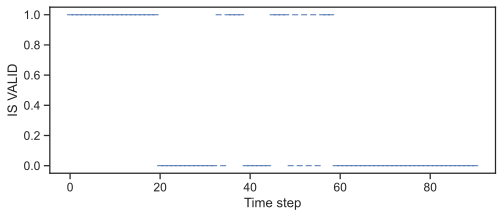

In [21]:
# Valid indicates if the state of the vehicle was observed for each timepoint
plt.xlabel('Time step')
plt.ylabel('IS VALID');
plt.plot(traffic_scene['objects'][idx]['valid'], '_', lw=5)
plt.show()

In [22]:
# Each object has a goalPosition, an (x, y) position within the scene
traffic_scene['objects'][idx]['goalPosition']

{'x': 9041.1259765625, 'y': -2716.647216796875}

In [23]:
# Finally, we have the type of the vehicle
traffic_scene['objects'][idx]['type']

'pedestrian'

### In-Depth: Road Points

Road points are static objects in the scene.

In [24]:
traffic_scene['roads'][idx].keys()

dict_keys(['geometry', 'type'])

In [25]:
# This point represents the edge of a road
traffic_scene['roads'][idx]['type']

'road_edge'

In [26]:
# Geometry contains the (x, y) position(s) for a road point
# Note that this will be a list for road lanes and edges but a single (x, y) tuple for stop signs and alike
print(json.dumps(traffic_scene['roads'][idx]['geometry'][:10], indent=4));

[
    {
        "x": 8922.911733810946,
        "y": -2849.426741530589
    },
    {
        "x": 8923.216436260553,
        "y": -2849.038518766975
    },
    {
        "x": 8923.50673911804,
        "y": -2848.63941352788
    },
    {
        "x": 8923.782254084921,
        "y": -2848.2299596442986
    },
    {
        "x": 8924.042612639492,
        "y": -2847.8107047886665
    },
    {
        "x": 8924.287466537296,
        "y": -2847.382209743547
    },
    {
        "x": 8924.516488266596,
        "y": -2846.945047650609
    },
    {
        "x": 8924.729371495881,
        "y": -2846.49980324385
    },
    {
        "x": 8924.91688626026,
        "y": -2846.067714357487
    },
    {
        "x": 8925.087545312272,
        "y": -2845.6286986979553
    }
]
